In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pandas as pd
import pickle
import os

palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='whitegrid', font="cmr10", font_scale=1.0)
plt.rcParams['axes.formatter.use_mathtext'] = True

In [64]:
with open('data/spikes/reversals.pkl', 'rb') as f:
    reversals = pickle.load(f)

dfs = []
columns = ['type', 'monkey', 'session', 'block', 'before', 'after', 'accuracy']
for monkey in ['V', 'W']:
    for session in [0,1,2,3]:
        file = f"monkey{monkey}_session{session}"
        mat = scipy.io.loadmat(f'data/spikes/{file}_values.mat')
        before = reversals[f"monkey{monkey}_session{session}"]['before']
        after = reversals[f"monkey{monkey}_session{session}"]['after']
        block = reversals[f"monkey{monkey}_session{session}"]['block']
        for mt in ['monkey', 'model']:
            df = pd.DataFrame(columns=columns)
            df['type'] = [mt for _ in range(block.shape[0])]
            df['monkey'] = [monkey for _ in range(block.shape[0])]
            df['session'] = [session for _ in range(block.shape[0])]
            df['block'] = block
            df['before'] = before
            df['after'] = after
            if mt=='model':
                acc = mat['acc'][0]
            elif mt=='monkey':
                acc = reversals[f"monkey{monkey}_session{session}"]['monkey_acc']
            df['accuracy'] = acc
            dfs.append(df)
acc = pd.concat(dfs, ignore_index=True)

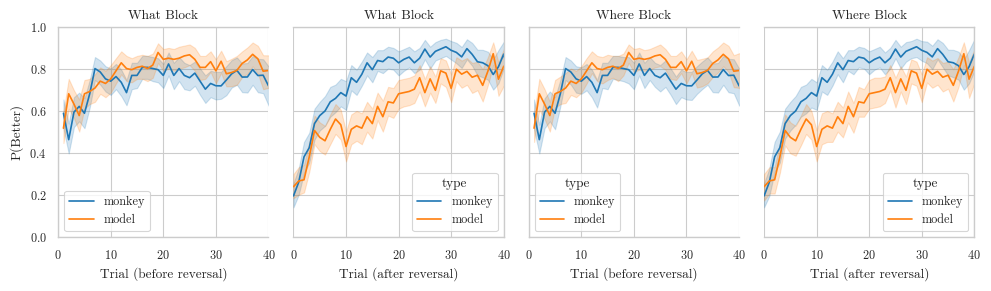

In [69]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, sharex=True, figsize=(10, 3))
sns.lineplot(acc, x='before', y='accuracy', hue='type', palette=palette[:2], ax=axes[0])
sns.lineplot(acc, x='after', y='accuracy', hue='type', palette=palette[:2], ax=axes[1])
sns.lineplot(acc, x='before', y='accuracy', hue='type', palette=palette[:2], ax=axes[2])
sns.lineplot(acc, x='after', y='accuracy', hue='type', palette=palette[:2], ax=axes[3])
axes[0].legend()
axes[0].set(ylabel="P(Better)", xlabel='Trial (before reversal)', title='What Block', xlim=(0, 40), ylim=(0, 1))
axes[1].set(xlabel='Trial (after reversal)', title='What Block')
axes[2].set(xlabel='Trial (before reversal)', title='Where Block')
axes[3].set(xlabel='Trial (after reversal)', title='Where Block')
axes[0].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[3].spines['left'].set_visible(False)
fig.tight_layout()
fig.savefig("plots/compare_accuracy.jpg", dpi=600)

## Create reversals data file from my other data file

In [59]:
empirical = pd.read_pickle("data/empirical.pkl")
reversal_dict = {}
for monkey in ['V', 'W']:
    for session in [0,1,2,3]:
        before = []
        after = []
        block = []
        monkey_acc = []
        for bid in range(1, 24+1):
            if os.path.exists(f'data/spikes/monkey{monkey}_session{session}_block{bid}_values.npz'):
                for trial in empirical.query("monkey==@monkey & session==@session & bid==@bid")['trial'].unique():
                    reversal_at_trial = empirical.query("monkey==@monkey & session==@session & bid==@bid")['reversal_at_trial'].unique()[0]
                    before.append(int(trial) if trial<reversal_at_trial else None)
                    after.append(int(trial - reversal_at_trial) if trial>=reversal_at_trial else None)
                    block.append("what" if bid<=12 else "where")
                    monkey_acc.append(empirical.query("monkey==@monkey & session==@session & bid==@bid & trial==@trial")['monkey_accuracy'].to_numpy())
            else:
                print("missing values", monkey, session, bid)
        reversal_dict[f"monkey{monkey}_session{session}"] = {
            'before': np.array(before),
            'after': np.array(after),
            'block': np.array(block),
            'monkey_acc': np.array(monkey_acc).flatten()
        }
with open('data/spikes/reversals.pkl', 'wb') as f:
    pickle.dump(reversal_dict, f)

missing values W 0 10
missing values W 0 18
missing values W 0 19
missing values W 0 20
missing values W 0 21
missing values W 0 22
missing values W 0 23
missing values W 0 24
missing values W 2 12
